In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model # Import Model for custom layers/attention
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Bidirectional, Dropout, Input, Permute, multiply, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K # For Keras backend operations
from scikeras.wrappers import KerasClassifier # Wrapper for Keras models in scikit-learn

In [3]:
df = pd.read_csv("comments_df.csv")

In [4]:
df.head()

,comment,sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [25]:
df['comment'] = df['comment'].astype(str).fillna('')

print("Actual Dataset Info")
print(df.info())
print("\nDataFrame Head:")
print(df.head())
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

Actual Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150099 entries, 0 to 150098
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   comment            150099 non-null  object
 1   sentiment          150099 non-null  object
 2   sentiment_encoded  150099 non-null  int32 
 3   comment_length     150099 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 4.0+ MB
None

DataFrame Head:
                                             comment sentiment  \
0  lets not forget that apple pay in 2014 require...   neutral   
1  here in nz 50 of retailers don’t even have con...  negative   
2  i will forever acknowledge this channel with t...  positive   
3  whenever i go to a place that doesn’t take app...  negative   
4  apple pay is so convenient secure and easy to ...  positive   

   sentiment_encoded  comment_length  
0                  1             317  
1                  0     

In [16]:
df['comment_length'] = df['comment'].apply(len)

In [5]:
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

In [6]:
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

negative: 0
neutral: 1
positive: 2


In [26]:
X = df['comment'].astype(str).fillna('')
y = df['sentiment_encoded'].values
num_classes = len(label_encoder.classes_)

In [27]:
print(f"\nTotal samples: {len(X)}")
print(f"Number of classes: {num_classes}")


Total samples: 150099
Number of classes: 3


In [28]:
vocab_size_rnn_lstm_gru = 10000 # Max vocabulary size for Keras Tokenizer
max_len_rnn_lstm_gru = 100 # Max length for padding sequences
embedding_dim_rnn_lstm_gru = 100 # Set to 100 to match glove.6B.100d.txt

In [29]:
tokenizer_rnn_lstm_gru = Tokenizer(num_words=vocab_size_rnn_lstm_gru, oov_token="<OOV>")
tokenizer_rnn_lstm_gru.fit_on_texts(X) # Fit on 'comment' column

In [30]:
sequences_rnn_lstm_gru = tokenizer_rnn_lstm_gru.texts_to_sequences(X) # Convert 'comment' to sequences
X_padded_rnn_lstm_gru = pad_sequences(sequences_rnn_lstm_gru, maxlen=max_len_rnn_lstm_gru, padding='post', truncating='post')

In [31]:
# Split data for all RNN/LSTM models
X_train_rnn_lstm_gru, X_test_rnn_lstm_gru, y_train_rnn_lstm_gru, y_test_rnn_lstm_gru = train_test_split(
    X_padded_rnn_lstm_gru, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train_rnn_lstm_gru.shape)
print(X_test_rnn_lstm_gru.shape)
print(y_train_rnn_lstm_gru.shape)
print(y_test_rnn_lstm_gru.shape)

(120079, 100)
(30020, 100)
(120079,)
(30020,)


In [32]:
# Load GloVe Embeddings
glove_file_path = 'C:\\Users\\USER\\Downloads\\glove.6B\\glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors in GloVe.")

Found 400000 word vectors in GloVe.


In [35]:
# Creating embedding matrix for Keras Embedding layer
# This matrix contains the GloVe vector for each word in our tokenizer's vocabulary
# Words not found in GloVe will have zero vectors
embedding_matrix = np.zeros((vocab_size_rnn_lstm_gru, embedding_dim_rnn_lstm_gru))
for word, i in tokenizer_rnn_lstm_gru.word_index.items():
    if i < vocab_size_rnn_lstm_gru: # Ensure word index is within our vocabulary size limit
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [36]:
# Helper function for plotting training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [37]:
# Custom Attention Layer (Bahdanau-style)
# This layer learns to weigh the importance of different parts of the input sequence.
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape is (batch_size, sequence_length, features)
        # W is the weight matrix for the attention mechanism, applied to the input features.
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        # b is the bias vector for the attention mechanism, applied across the sequence length.
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x is (batch_size, sequence_length, features)
        # Apply a dense layer (dot product with W + bias b) to get scores for each timestep
        # K.tanh is used as the activation function for the scoring mechanism.
        e = K.tanh(K.dot(x, self.W) + self.b) # Output shape: (batch_size, sequence_length, 1)
        # Squeeze the last dimension to get (batch_size, sequence_length)
        e = K.squeeze(e, axis=-1) # Output shape: (batch_size, sequence_length)

        # Apply softmax to get attention weights. These weights sum to 1 across the sequence.
        alpha = K.softmax(e) # Output shape: (batch_size, sequence_length)

        # Reshape alpha to (batch_size, sequence_length, 1) for element-wise multiplication with input x
        alpha = K.expand_dims(alpha, axis=-1)

        # Multiply the attention weights by the input sequence. This re-weights each word's features.
        output = x * alpha # Output shape: (batch_size, sequence_length, features)

        # Sum over the sequence length (axis=1) to get the context vector.
        # This context vector is a weighted sum of the input features, emphasizing important words.
        output = K.sum(output, axis=1) # Output shape: (batch_size, features)
        return output

    def get_config(self):
        # This is necessary for saving/loading models that include custom layers
        return super(Attention, self).get_config()

In [38]:
# Early Stopping callback for individual model training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [39]:
# Deep BiLSTM Model with Attention
def create_deep_bilstm_model(learning_rate=0.001, dropout_rate=0.3, lstm_units_1=64, lstm_units_2=32):
    lstm_input = Input(shape=(max_len_rnn_lstm_gru,))
    # Use pre-trained GloVe embeddings
    lstm_embedding = Embedding(
        vocab_size_rnn_lstm_gru,
        embedding_dim_rnn_lstm_gru,
        weights=[embedding_matrix], # Initialize with GloVe weights
        input_length=max_len_rnn_lstm_gru,
        trainable=False # Set to False to keep embeddings fixed, True to fine-tune them
    )(lstm_input)

    # First Bidirectional LSTM layer, returns full sequences
    lstm_layer_1 = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(lstm_embedding)
    lstm_dropout_1 = Dropout(dropout_rate)(lstm_layer_1)
    # Second Bidirectional LSTM layer, returns full sequences for attention
    lstm_layer_2 = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(lstm_dropout_1)
    lstm_dropout_2 = Dropout(dropout_rate)(lstm_layer_2)

    # Apply Attention mechanism to the output of the last recurrent layer
    attention_output = Attention()(lstm_dropout_2)

    # Final dense layer for classification
    lstm_output = Dense(num_classes, activation='softmax')(attention_output)

    model = Model(inputs=lstm_input, outputs=lstm_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
# Deep SimpleRNN Model with Attention
def create_deep_rnn_model(learning_rate=0.001, dropout_rate=0.3, rnn_units_1=64, rnn_units_2=32):
    rnn_input = Input(shape=(max_len_rnn_lstm_gru,))
    # Use pre-trained GloVe embeddings
    rnn_embedding = Embedding(
        vocab_size_rnn_lstm_gru,
        embedding_dim_rnn_lstm_gru,
        weights=[embedding_matrix], # Initialize with GloVe weights
        input_length=max_len_rnn_lstm_gru,
        trainable=False # Set to False to keep embeddings fixed, True to fine-tune them
    )(rnn_input)

    # First SimpleRNN layer, returns full sequences
    rnn_layer_1 = SimpleRNN(rnn_units_1, return_sequences=True)(rnn_embedding)
    rnn_dropout_1 = Dropout(dropout_rate)(rnn_layer_1)
    # Second SimpleRNN layer, returns full sequences for attention
    rnn_layer_2 = SimpleRNN(rnn_units_2, return_sequences=True)(rnn_dropout_1)
    rnn_dropout_2 = Dropout(dropout_rate)(rnn_layer_2)

    # Apply Attention mechanism
    attention_output_rnn = Attention()(rnn_dropout_2)

    # Final dense layer for classification
    rnn_output = Dense(num_classes, activation='softmax')(attention_output_rnn)

    model = Model(inputs=rnn_input, outputs=rnn_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [42]:
# Stacked LSTM Model with Attention (Unidirectional)
def create_stacked_lstm_model(learning_rate=0.001, dropout_rate=0.3, lstm_units_1=64, lstm_units_2=32):
    lstm_input = Input(shape=(max_len_rnn_lstm_gru,))
    # Using pre-trained GloVe embeddings
    lstm_embedding = Embedding(
        vocab_size_rnn_lstm_gru,
        embedding_dim_rnn_lstm_gru,
        weights=[embedding_matrix], # Initialized with GloVe weights
        input_length=max_len_rnn_lstm_gru,
        trainable=False # Set to False to keep embeddings fixed, True to fine-tune them
    )(lstm_input)

    # First LSTM layer, returns full sequences
    lstm_layer_1 = LSTM(lstm_units_1, return_sequences=True)(lstm_embedding)
    lstm_dropout_1 = Dropout(dropout_rate)(lstm_layer_1)
    # Second LSTM layer, returns full sequences for attention
    lstm_layer_2 = LSTM(lstm_units_2, return_sequences=True)(lstm_dropout_1)
    lstm_dropout_2 = Dropout(dropout_rate)(lstm_layer_2)

    # Apply Attention mechanism
    attention_output = Attention()(lstm_dropout_2)

    # Final dense layer for classification
    lstm_output = Dense(num_classes, activation='softmax')(attention_output)

    model = Model(inputs=lstm_input, outputs=lstm_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [44]:
# Hyperparameter Tuning Setup (Subset for faster tuning)
tuning_subset_size = min(10000, len(X_train_rnn_lstm_gru)) # Using up to 10,000 samples for tuning
X_tune = X_train_rnn_lstm_gru[:tuning_subset_size]
y_tune = y_train_rnn_lstm_gru[:tuning_subset_size]

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,126,055 (4.30 MB)

 Trainable params: 126,055 (492.40 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 668s 385ms/step - accuracy: 0.5990 - loss: 0.8525 - val_accuracy: 0.6868 - val_loss: 0.7083
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 652s 386ms/step - accuracy: 0.6934 - loss: 0.6993 - val_accuracy: 0.7040 - val_loss: 0.6743
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 685s 387ms/step - accuracy: 0.7191 - loss: 0.6440 - val_accuracy: 0.7249 - val_loss: 0.6376
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 685s 405ms/step - accuracy: 0.7411 - loss: 0.5977 - val_accuracy: 0.7320 - val_loss: 0.6135
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 664s 393ms/step - accuracy: 0.7617 - loss: 0.5568 - val_accuracy: 0.7386 - val_loss: 0.6063
Restoring model weights from the end of the best epoch: 5.
Initial Deep BiLSTM Test Loss: 0.6057
Initial Deep BiLSTM Test Accuracy: 0.7394


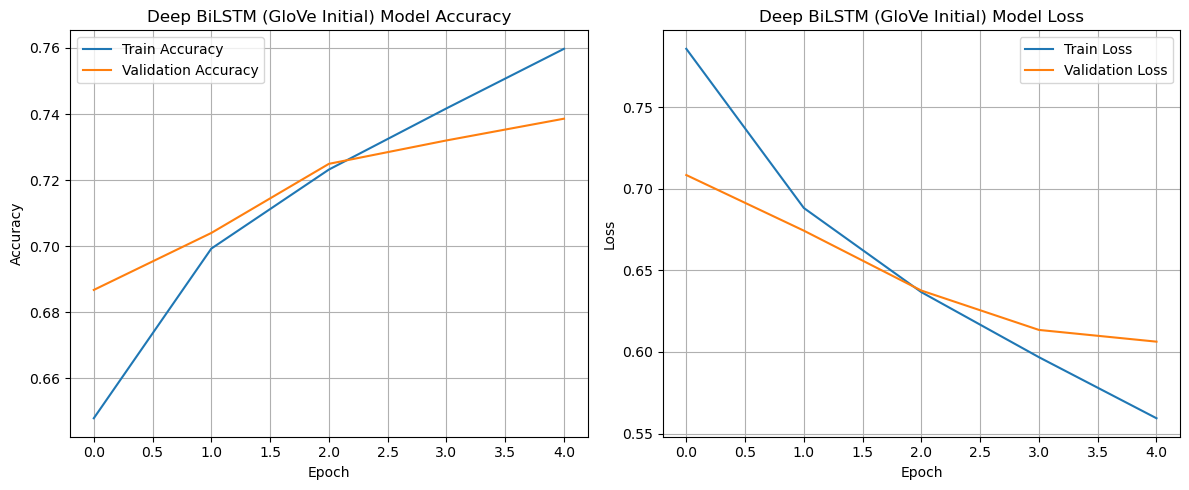

In [45]:
# Deep BiLSTM Model with Attention (using GloVe)
# Initial Training with Default Parameters
initial_bilstm_model = create_deep_bilstm_model() # Using default parameters
initial_bilstm_model.summary()

history_initial_bilstm = initial_bilstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_initial_bilstm, accuracy_initial_bilstm = initial_bilstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Initial Deep BiLSTM Test Loss: {loss_initial_bilstm:.4f}")
print(f"Initial Deep BiLSTM Test Accuracy: {accuracy_initial_bilstm:.4f}")
plot_training_history(history_initial_bilstm, 'Deep BiLSTM (GloVe Initial)')

In [46]:
# Hyperparameter Tuning for Deep BiLSTM
bilstm_classifier = KerasClassifier(model=create_deep_bilstm_model, verbose=0)
param_dist_bilstm = {
    'model__learning_rate': uniform(loc=1e-4, scale=1e-3),
    'model__dropout_rate': uniform(loc=0.2, scale=0.3),
    'model__lstm_units_1': randint(32, 96),
    'model__lstm_units_2': randint(16, 48),
    'batch_size': [32, 64],
    'epochs': [5, 10]
}
random_search_bilstm = RandomizedSearchCV(
    estimator=bilstm_classifier, param_distributions=param_dist_bilstm,
    n_iter=3, cv=2, verbose=2, random_state=42, n_jobs=1
)
random_search_bilstm.fit(X_tune, y_tune, callbacks=[early_stopping])
print(f"Best Score: {random_search_bilstm.best_score_:.4f}")
print(f"Best Parameters: {random_search_bilstm.best_params_}")
best_bilstm_model_params = random_search_bilstm.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time=10.5min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time=12.2min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time=10.0min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 6.2min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 3.1min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 3.1min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best Score: 0.6440
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.4852142919229748, 'model__learning_rate': 0.0008319939418114052, 'model__lstm_units_1': 92, 'model__lstm_units_2': 36}


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 100, 184)       │       142,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 184)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 100, 72)        │        63,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 72)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_8 (Attention)         │ (None, 72)             │           172 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,087 (4.60 MB)

 Trainable params: 206,087 (805.03 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 670s 193ms/step - accuracy: 0.6030 - loss: 0.8434 - val_accuracy: 0.6945 - val_loss: 0.6969
Epoch 2/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1108s 328ms/step - accuracy: 0.6985 - loss: 0.6869 - val_accuracy: 0.7156 - val_loss: 0.6510
Epoch 3/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1111s 329ms/step - accuracy: 0.7294 - loss: 0.6266 - val_accuracy: 0.7352 - val_loss: 0.6167
Epoch 4/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 886s 262ms/step - accuracy: 0.7562 - loss: 0.5714 - val_accuracy: 0.7398 - val_loss: 0.5979
Epoch 5/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1092s 323ms/step - accuracy: 0.7781 - loss: 0.5226 - val_accuracy: 0.7552 - val_loss: 0.5728
Epoch 6/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1091s 323ms/step - accuracy: 0.8129 - loss: 0.4452 - val_accuracy: 0.7650 - val_loss: 0.5756
Epoch 8/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1308s 387ms/step - accuracy: 0.8292 - loss: 0.4125 - val_accuracy: 0.7794 - val_loss: 0.5274
Epoch 9/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 1178s 348ms/ste

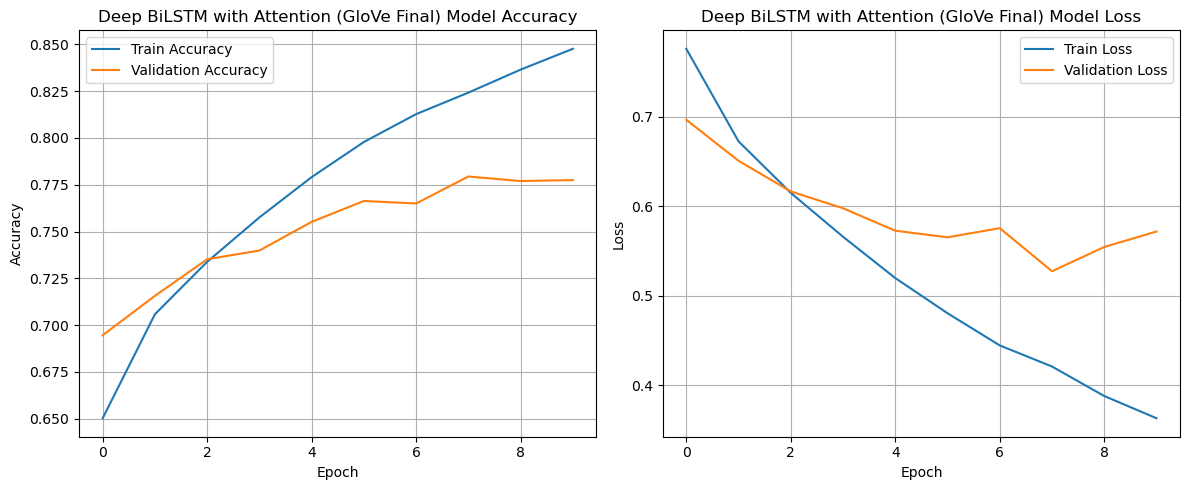

In [47]:
# Final Training with Best Parameters for Deep BiLSTM
final_bilstm_model = create_deep_bilstm_model(
    learning_rate=best_bilstm_model_params['model__learning_rate'],
    dropout_rate=best_bilstm_model_params['model__dropout_rate'],
    lstm_units_1=best_bilstm_model_params['model__lstm_units_1'],
    lstm_units_2=best_bilstm_model_params['model__lstm_units_2']
)
final_bilstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_bilstm_model_params['model__learning_rate']),
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_bilstm_model.summary()

history_final_bilstm = final_bilstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=10,
    batch_size=best_bilstm_model_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_final_bilstm, accuracy_final_bilstm = final_bilstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Final Deep BiLSTM Test Loss: {loss_final_bilstm:.4f}")
print(f"Final Deep BiLSTM Test Accuracy: {accuracy_final_bilstm:.4f}")
y_pred_final_bilstm = np.argmax(final_bilstm_model.predict(X_test_rnn_lstm_gru), axis=-1)
print(classification_report(y_test_rnn_lstm_gru, y_pred_final_bilstm, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_rnn_lstm_gru, y_pred_final_bilstm))
plot_training_history(history_final_bilstm, 'Deep BiLSTM with Attention (GloVe Final)')

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_9 (Attention)         │ (None, 32)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,895 (3.87 MB)

 Trainable params: 13,895 (54.28 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 150s 84ms/step - accuracy: 0.5550 - loss: 0.9058 - val_accuracy: 0.6490 - val_loss: 0.7963
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 150s 89ms/step - accuracy: 0.6523 - loss: 0.7881 - val_accuracy: 0.6567 - val_loss: 0.7720
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 199s 87ms/step - accuracy: 0.6641 - loss: 0.7652 - val_accuracy: 0.6737 - val_loss: 0.7367
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 155s 91ms/step - accuracy: 0.6698 - loss: 0.7487 - val_accuracy: 0.6665 - val_loss: 0.7473
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 178s 105ms/step - accuracy: 0.6801 - loss: 0.7331 - val_accuracy: 0.6770 - val_loss: 0.7317
Restoring model weights from the end of the best epoch: 5.
Initial Deep SimpleRNN Test Loss: 0.7382
Initial Deep SimpleRNN Test Accuracy: 0.6763


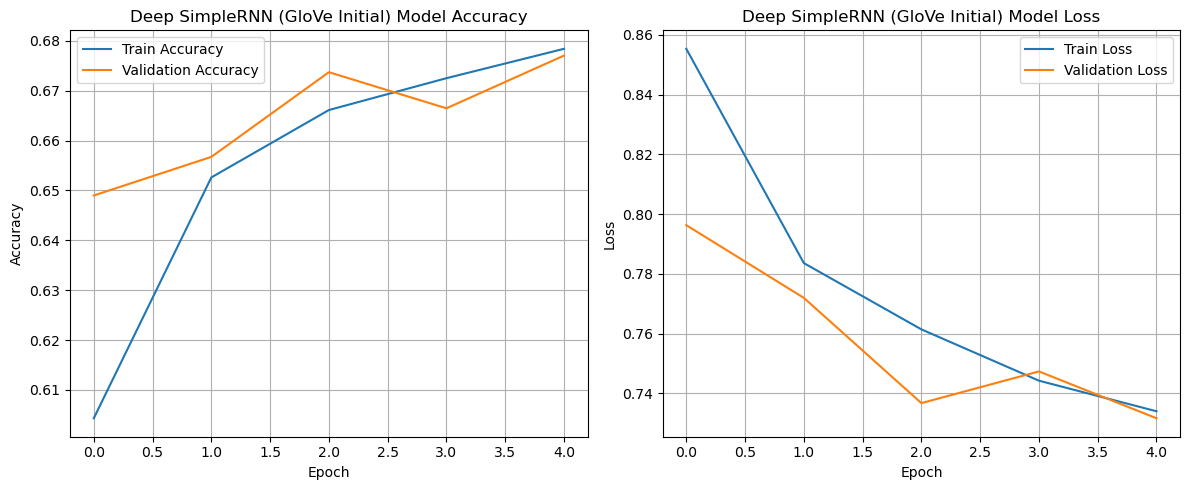

In [48]:
# Deep SimpleRNN Model with Attention (using GloVe)
# Initial Training with Default Parameters
initial_rnn_model = create_deep_rnn_model() # Using default parameters
initial_rnn_model.summary()

history_initial_rnn = initial_rnn_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_initial_rnn, accuracy_initial_rnn = initial_rnn_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Initial Deep SimpleRNN Test Loss: {loss_initial_rnn:.4f}")
print(f"Initial Deep SimpleRNN Test Accuracy: {accuracy_initial_rnn:.4f}")
plot_training_history(history_initial_rnn, 'Deep SimpleRNN (GloVe Initial)')

In [53]:
# Hyperparameter Tuning for Deep SimpleRNN
rnn_classifier = KerasClassifier(model=create_deep_rnn_model, verbose=0)
param_dist_rnn = {
    'model__learning_rate': uniform(loc=1e-4, scale=1e-3),
    'model__dropout_rate': uniform(loc=0.2, scale=0.3),
    'model__rnn_units_1': randint(32, 96),
    'model__rnn_units_2': randint(16, 48),
    'batch_size': [32, 64],
    'epochs': [5, 10]
}
random_search_rnn = RandomizedSearchCV(
    estimator=rnn_classifier, param_distributions=param_dist_rnn,
    n_iter=3, cv=2, verbose=2, random_state=42, n_jobs=1
)
random_search_rnn.fit(X_tune, y_tune, callbacks=[early_stopping])
print(f"Best Score: {random_search_rnn.best_score_:.4f}")
print(f"Best Parameters: {random_search_rnn.best_params_}")
best_rnn_model_params = random_search_rnn.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__rnn_units_1=92, model__rnn_units_2=36; total time= 2.3min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__rnn_units_1=92, model__rnn_units_2=36; total time= 3.0min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__rnn_units_1=55, model__rnn_units_2=36; total time= 2.4min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__rnn_units_1=55, model__rnn_units_2=36; total time= 2.9min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__rnn_units_1=33, model__rnn_units_2=39; total time= 1.5min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__rnn_units_1=33, model__rnn_units_2=39; total time= 1.5min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best Score: 0.6180
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.4852142919229748, 'model__learning_rate': 0.0008319939418114052, 'model__rnn_units_1': 92, 'model__rnn_units_2': 36}


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_33 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 100, 92)        │        17,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 100, 92)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 100, 36)        │         4,644 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 100, 36)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_33 (Attention)        │ (None, 36)             │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,647 (3.90 MB)

 Trainable params: 22,647 (88.46 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 330s 95ms/step - accuracy: 0.5599 - loss: 0.9070 - val_accuracy: 0.6218 - val_loss: 0.8326
Epoch 2/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 354s 87ms/step - accuracy: 0.6330 - loss: 0.8212 - val_accuracy: 0.6170 - val_loss: 0.8502
Epoch 3/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 302s 89ms/step - accuracy: 0.6491 - loss: 0.7898 - val_accuracy: 0.6646 - val_loss: 0.7649
Epoch 4/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 631s 187ms/step - accuracy: 0.6805 - loss: 0.7353 - val_accuracy: 0.6845 - val_loss: 0.7271
Epoch 7/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 322s 95ms/step - accuracy: 0.6814 - loss: 0.7354 - val_accuracy: 0.6798 - val_loss: 0.7324
Epoch 8/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 308s 91ms/step - accuracy: 0.6871 - loss: 0.7228 - val_accuracy: 0.6886 - val_loss: 0.7154
Epoch 9/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 283s 84ms/step - accuracy: 0.6906 - loss: 0.7119 - val_accuracy: 0.6821 - val_loss: 0.7195
Epoch 10/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 290s 86ms/step - accuracy

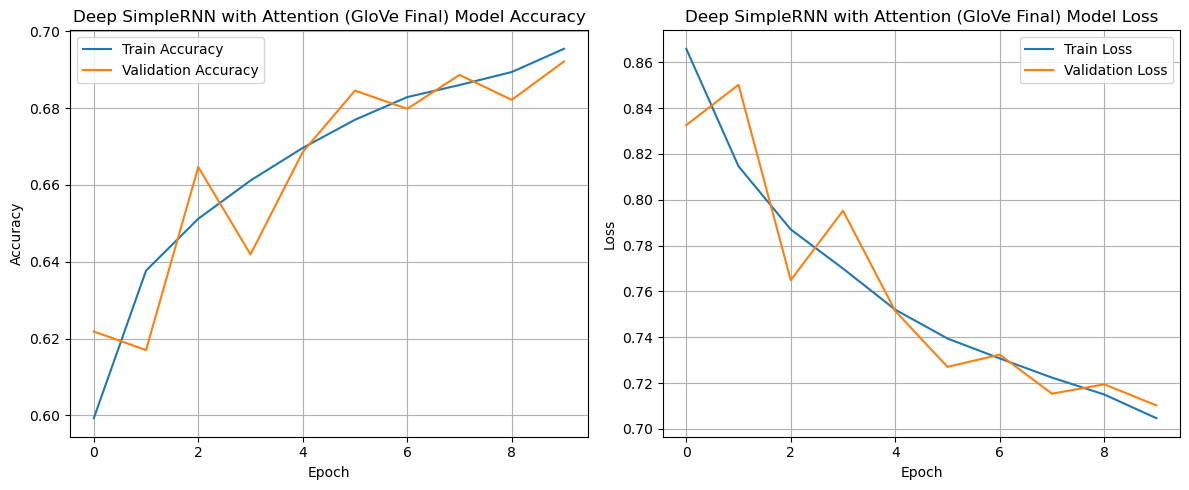

In [54]:
# Final Training with Best Parameters for Deep SimpleRNN
final_rnn_model = create_deep_rnn_model(
    learning_rate=best_rnn_model_params['model__learning_rate'],
    dropout_rate=best_rnn_model_params['model__dropout_rate'],
    rnn_units_1=best_rnn_model_params['model__rnn_units_1'],
    rnn_units_2=best_rnn_model_params['model__rnn_units_2']
)
final_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_rnn_model_params['model__learning_rate']),
                        loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_rnn_model.summary()

history_final_rnn = final_rnn_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=10,
    batch_size=best_rnn_model_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_final_rnn, accuracy_final_rnn = final_rnn_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Final Deep SimpleRNN Test Loss: {loss_final_rnn:.4f}")
print(f"Final Deep SimpleRNN Test Accuracy: {accuracy_final_rnn:.4f}")
y_pred_final_rnn = np.argmax(final_rnn_model.predict(X_test_rnn_lstm_gru), axis=-1)
print(classification_report(y_test_rnn_lstm_gru, y_pred_final_rnn, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_rnn_lstm_gru, y_pred_final_rnn))
plot_training_history(history_final_rnn, 'Deep SimpleRNN with Attention (GloVe Final)')

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_10 (Attention)        │ (None, 32)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,887 (4.02 MB)

 Trainable params: 54,887 (214.40 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 320s 184ms/step - accuracy: 0.5955 - loss: 0.8615 - val_accuracy: 0.6814 - val_loss: 0.7294
Epoch 2/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 333s 190ms/step - accuracy: 0.6868 - loss: 0.7154 - val_accuracy: 0.7024 - val_loss: 0.6844
Epoch 3/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 315s 187ms/step - accuracy: 0.7110 - loss: 0.6631 - val_accuracy: 0.7125 - val_loss: 0.6562
Epoch 4/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 319s 189ms/step - accuracy: 0.7290 - loss: 0.6287 - val_accuracy: 0.7241 - val_loss: 0.6381
Epoch 5/5
1689/1689 ━━━━━━━━━━━━━━━━━━━━ 340s 202ms/step - accuracy: 0.7438 - loss: 0.5980 - val_accuracy: 0.7277 - val_loss: 0.6294
Restoring model weights from the end of the best epoch: 5.
Initial Stacked LSTM Test Loss: 0.6259
Initial Stacked LSTM Test Accuracy: 0.7281


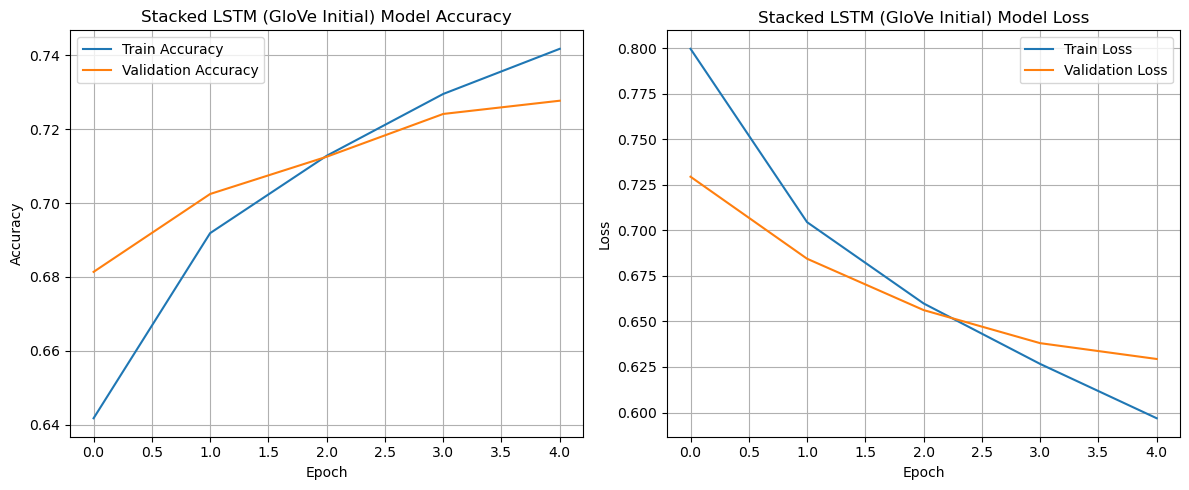

In [49]:
# Stacked LSTM Model with Attention (using GloVe)
# Initial Training with Default Parameters
initial_stacked_lstm_model = create_stacked_lstm_model() # Using default parameters
initial_stacked_lstm_model.summary()

history_initial_stacked_lstm = initial_stacked_lstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_initial_stacked_lstm, accuracy_initial_stacked_lstm = initial_stacked_lstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Initial Stacked LSTM Test Loss: {loss_initial_stacked_lstm:.4f}")
print(f"Initial Stacked LSTM Test Accuracy: {accuracy_initial_stacked_lstm:.4f}")
plot_training_history(history_initial_stacked_lstm, 'Stacked LSTM (GloVe Initial)')

In [51]:
# Hyperparameter Tuning for Stacked LSTM
stacked_lstm_classifier = KerasClassifier(model=create_stacked_lstm_model, verbose=0)
param_dist_stacked_lstm = {
    'model__learning_rate': uniform(loc=1e-4, scale=1e-3),
    'model__dropout_rate': uniform(loc=0.2, scale=0.3),
    'model__lstm_units_1': randint(32, 96),
    'model__lstm_units_2': randint(16, 48),
    'batch_size': [32, 64],
    'epochs': [5, 10]
}
random_search_stacked_lstm = RandomizedSearchCV(
    estimator=stacked_lstm_classifier, param_distributions=param_dist_stacked_lstm,
    n_iter=3, cv=2, verbose=2, random_state=42, n_jobs=1
)
random_search_stacked_lstm.fit(X_tune, y_tune, callbacks=[early_stopping])
print(f"Best Score: {random_search_stacked_lstm.best_score_:.4f}")
print(f"Best Parameters: {random_search_stacked_lstm.best_params_}")
best_stacked_lstm_model_params = random_search_stacked_lstm.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time= 2.0min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.4852142919229748, model__learning_rate=0.0008319939418114052, model__lstm_units_1=92, model__lstm_units_2=36; total time= 1.7min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 2.2min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.24679835610086082, model__learning_rate=0.00015808361216819946, model__lstm_units_1=55, model__lstm_units_2=36; total time= 2.3min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 1.4min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4124217733388137, model__learning_rate=0.00012058449429580245, model__lstm_units_1=33, model__lstm_units_2=39; total time= 1.4min


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best Score: 0.6378
Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.4852142919229748, 'model__learning_rate': 0.0008319939418114052, 'model__lstm_units_1': 92, 'model__lstm_units_2': 36}


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_25 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 100, 92)        │        71,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 100, 92)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 100, 36)        │        18,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 100, 36)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_25 (Attention)        │ (None, 36)             │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089,847 (4.16 MB)

 Trainable params: 89,847 (350.96 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 249s 73ms/step - accuracy: 0.6054 - loss: 0.8483 - val_accuracy: 0.6867 - val_loss: 0.7283
Epoch 2/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 289s 85ms/step - accuracy: 0.6963 - loss: 0.7011 - val_accuracy: 0.7099 - val_loss: 0.6680
Epoch 3/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 285s 84ms/step - accuracy: 0.7204 - loss: 0.6475 - val_accuracy: 0.7206 - val_loss: 0.6392
Epoch 4/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 290s 86ms/step - accuracy: 0.7431 - loss: 0.5998 - val_accuracy: 0.7287 - val_loss: 0.6281
Epoch 5/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 290s 86ms/step - accuracy: 0.7571 - loss: 0.5672 - val_accuracy: 0.7346 - val_loss: 0.6078
Epoch 6/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 351s 104ms/step - accuracy: 0.7747 - loss: 0.5277 - val_accuracy: 0.7480 - val_loss: 0.5881
Epoch 7/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 496s 147ms/step - accuracy: 0.7889 - loss: 0.4970 - val_accuracy: 0.7462 - val_loss: 0.6109
Epoch 8/10
3378/3378 ━━━━━━━━━━━━━━━━━━━━ 491s 145ms/step - accurac

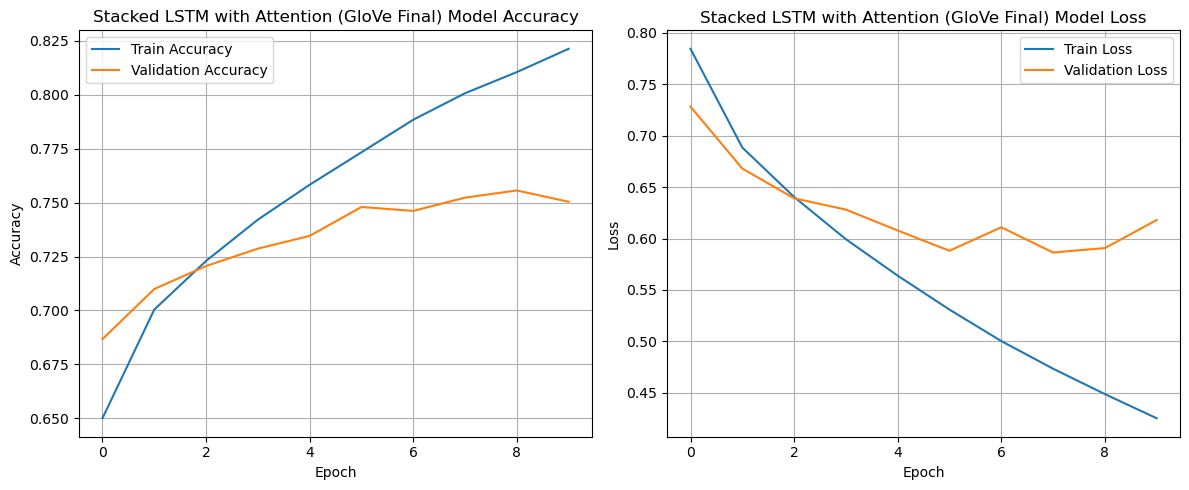

In [52]:
# Final Training with Best Parameters for Stacked LSTM
final_stacked_lstm_model = create_stacked_lstm_model(
    learning_rate=best_stacked_lstm_model_params['model__learning_rate'],
    dropout_rate=best_stacked_lstm_model_params['model__dropout_rate'],
    lstm_units_1=best_stacked_lstm_model_params['model__lstm_units_1'],
    lstm_units_2=best_stacked_lstm_model_params['model__lstm_units_2']
)
final_stacked_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_stacked_lstm_model_params['model__learning_rate']),
                                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_stacked_lstm_model.summary()

history_final_stacked_lstm = final_stacked_lstm_model.fit(
    X_train_rnn_lstm_gru, y_train_rnn_lstm_gru,
    epochs=10,
    batch_size=best_stacked_lstm_model_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
loss_final_stacked_lstm, accuracy_final_stacked_lstm = final_stacked_lstm_model.evaluate(X_test_rnn_lstm_gru, y_test_rnn_lstm_gru, verbose=0)
print(f"Final Stacked LSTM Test Loss: {loss_final_stacked_lstm:.4f}")
print(f"Final Stacked LSTM Test Accuracy: {accuracy_final_stacked_lstm:.4f}")
y_pred_final_stacked_lstm = np.argmax(final_stacked_lstm_model.predict(X_test_rnn_lstm_gru), axis=-1)
print(classification_report(y_test_rnn_lstm_gru, y_pred_final_stacked_lstm, target_names=label_encoder.classes_))
print(confusion_matrix(y_test_rnn_lstm_gru, y_pred_final_stacked_lstm))
plot_training_history(history_final_stacked_lstm, 'Stacked LSTM with Attention (GloVe Final)')

In [55]:
# Making Predictions on New Comments
def predict_sentiment(comment, model):
    # Preprocess for RNN/LSTM
    seq = tokenizer_rnn_lstm_gru.texts_to_sequences([comment])
    padded_seq = pad_sequences(seq, maxlen=max_len_rnn_lstm_gru, padding='post', truncating='post')
    prediction = model.predict(padded_seq)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    sentiment_label = label_encoder.inverse_transform([predicted_class])[0]
    return sentiment_label

In [56]:
# Example comments for prediction
# new_comments = [
#     "This video was absolutely fantastic, I loved every second!",
#     "The audio quality was terrible, couldn't hear anything.",
#     "It's an okay video, nothing groundbreaking but not bad either.",
#     "I'm so happy with this content, it's exactly what I needed.",
#     "This is the worst thing I've ever seen on YouTube."
# ]

In [57]:
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_bilstm_model)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative


In [58]:
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_rnn_model)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative


In [59]:
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_stacked_lstm_model)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative


In [67]:
new_comments = [
    "This video was absolutely fantastic, I loved every second!",
    "The audio quality was terrible, couldn't hear anything.",
    "It's an okay video, nothing groundbreaking but not bad either.",
    "I'm so happy with this content, it's exactly what I needed.",
    "This is the worst thing I've ever seen on YouTube.",
    "I have no strong feelings about this content.",
    "It's neither good nor bad, just informative.",
    "This is truly amazing, thank you!",
    "Absolutely horrible production.",
    "I'm indifferent to the topic discussed."
]

predictions_list = []
for comment in new_comments:
    sentiment = predict_sentiment(comment, final_bilstm_model)
    predictions_list.append(sentiment)
    print(f"Comment: '{comment}' -> Predicted Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Comment: 'This video was absolutely fantastic, I loved every second!' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Comment: 'The audio quality was terrible, couldn't hear anything.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Comment: 'It's an okay video, nothing groundbreaking but not bad either.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Comment: 'I'm so happy with this content, it's exactly what I needed.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Comment: 'This is the worst thing I've ever seen on YouTube.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Comment: 'I have no strong feelings about this content.' -> Predicted Sentiment: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Comment: 'It's neither good nor bad, just informative.' -> Predicted Sentiment: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
C

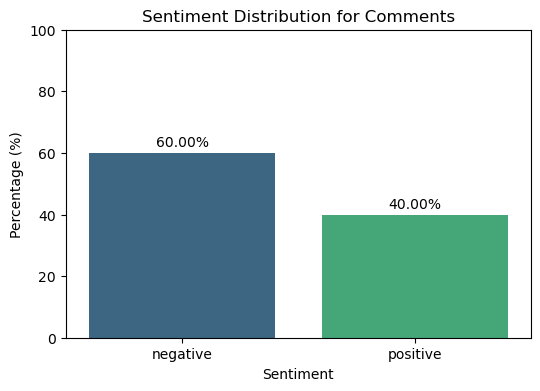


Sentiment Distribution for Comments
negative    60.0
positive    40.0
Name: proportion, dtype: float64


In [68]:
# Plotting Sentiment Distribution for New Comments
predictions_series = pd.Series(predictions_list)
sentiment_counts = predictions_series.value_counts(normalize=True) * 100 # Get percentage

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution for Comments')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100) # Ensure y-axis goes from 0 to 100
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 2, f'{value:.2f}%', ha='center') # Add percentage labels
plt.show()

print("\nSentiment Distribution for Comments")
print(sentiment_counts)

In [65]:
import pickle

In [66]:
# Save Trained Model Components
def save_model_components(model, tokenizer, label_encoder, model_path='best_bilstm_model.h5', tokenizer_path='tokenizer.pkl', label_encoder_path='label_encoder.pkl'):
    try:
        model.save(model_path)
        print(f"Model saved to {model_path}")

        # Save Tokenizer
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(tokenizer, f)
        print(f"Tokenizer saved to {tokenizer_path}")

        # Save LabelEncoder
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(label_encoder, f)
        print(f"LabelEncoder saved to {label_encoder_path}")
    except Exception as e:
        print(f"Error saving components: {e}")

# Call the save_model_components function to create the files
save_model_components(
    model=final_bilstm_model,
    tokenizer=tokenizer_rnn_lstm_gru, 
    label_encoder=label_encoder,      
    model_path='best_bilstm_model.h5',
    tokenizer_path='tokenizer.pkl',
    label_encoder_path='label_encoder.pkl'
)

Model saved to best_bilstm_model.h5
Tokenizer saved to tokenizer.pkl
LabelEncoder saved to label_encoder.pkl
